<a href="https://colab.research.google.com/github/Tejaswini2004-ai/Data-science-project/blob/main/internmain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn statsmodels prophet xgboost mlxtend plotly

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from mlxtend.frequent_patterns import apriori, association_rules
import plotly.express as px

In [3]:
df = pd.read_csv('/content/dataset.csv', parse_dates=['Transaction_ID'])
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    100000 non-null  object 
 1   Customer_ID       100000 non-null  object 
 2   Product_ID        100000 non-null  object 
 3   Transaction_Date  100000 non-null  object 
 4   Units_Sold        100000 non-null  int64  
 5   Discount_Applied  100000 non-null  float64
 6   Revenue           100000 non-null  float64
 7   Clicks            100000 non-null  int64  
 8   Impressions       100000 non-null  int64  
 9   Conversion_Rate   100000 non-null  float64
 10  Category          100000 non-null  object 
 11  Region            100000 non-null  object 
 12  Ad_CTR            100000 non-null  float64
 13  Ad_CPC            100000 non-null  float64
 14  Ad_Spend          100000 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 11.4+ MB
None
      

<ipython-input-3-2732205173>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/dataset.csv', parse_dates=['Transaction_ID'])


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    100000 non-null  object 
 1   Customer_ID       100000 non-null  object 
 2   Product_ID        100000 non-null  object 
 3   Transaction_Date  100000 non-null  object 
 4   Units_Sold        100000 non-null  int64  
 5   Discount_Applied  100000 non-null  float64
 6   Revenue           100000 non-null  float64
 7   Clicks            100000 non-null  int64  
 8   Impressions       100000 non-null  int64  
 9   Conversion_Rate   100000 non-null  float64
 10  Category          100000 non-null  object 
 11  Region            100000 non-null  object 
 12  Ad_CTR            100000 non-null  float64
 13  Ad_CPC            100000 non-null  float64
 14  Ad_Spend          100000 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 11.4+ MB


In [5]:
df.describe()

,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Ad_CTR,Ad_CPC,Ad_Spend
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,128.328580,0.149871,553.110811,24.539170,254.539060,0.198138,0.104988,1.051250,110.477240
std,49.679873,0.086692,428.366294,14.412477,141.466606,0.361187,0.054806,0.549252,87.015846
min,51.000000,0.000000,7.650000,0.000000,10.000000,0.000000,0.010000,0.100000,1.050000
25%,84.000000,0.070000,221.260000,12.000000,132.000000,0.050000,0.057500,0.580000,38.610000
50%,127.000000,0.150000,428.155000,25.000000,254.000000,0.100000,0.105200,1.050000,87.240000
75%,166.000000,0.220000,805.865000,37.000000,377.000000,0.190000,0.152300,1.530000,164.220000
max,716.000000,0.300000,5704.180000,49.000000,499.000000,4.900000,0.200000,2.000000,399.600000


In [11]:
# Ensure 'Transaction_Date' is parsed as datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')

# Calculate 'Sales_Amount' BEFORE RFM calculation

# Print column names to check for 'Quantity', 'Unit_Price', and 'Discount'
print("DataFrame columns:", df.columns)

# --- Start of suggested changes ---
# Check if the required columns exist in the DataFrame before attempting calculation
required_columns = ['Quantity', 'Unit_Price', 'Discount']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"Error: The following required columns are missing from the DataFrame: {missing_columns}")
    print("Please check your dataset file and ensure these columns are present.")
else:
    # Calculate 'Sales_Amount' if all required columns are present
    df['Sales_Amount'] = df['Quantity'] * df['Unit_Price'] * (1 - df['Discount'])

    # Now calculate snapshot_date safely AFTER ensuring data types are correct
    snapshot_date = df['Transaction_Date'].max() + pd.Timedelta(days=1)

    # Proceed with RFM calculation
    # Aggregate for Recency (max date) and Monetary (sum of Sales_Amount)
    rfm = df.groupby('Customer_ID').agg({
        'Transaction_Date': 'max', # Use max to find the last transaction date
        'Sales_Amount': 'sum',
    }).rename(columns={
        'Transaction_Date': 'Last_Transaction_Date', # Rename temporarily
        'Sales_Amount': 'Monetary'
    })

    # Calculate Recency from the last transaction date
    rfm['Recency'] = (snapshot_date - rfm['Last_Transaction_Date']).dt.days

    # Calculate Frequency separately as the count of transactions per customer
    frequency_df = df.groupby('Customer_ID').size().to_frame(name='Frequency')

    # Merge Recency and Monetary with Frequency
    rfm = rfm.merge(frequency_df, left_index=True, right_index=True)

    # Drop the temporary 'Last_Transaction_Date' column
    rfm = rfm.drop(columns=['Last_Transaction_Date'])

    # Reorder columns
    rfm = rfm[['Recency', 'Frequency', 'Monetary']]

    # Display the result
    print(rfm.head())

# --- End of suggested changes ---

DataFrame columns: Index(['Transaction_ID', 'Customer_ID', 'Product_ID', 'Transaction_Date',
       'Units_Sold', 'Discount_Applied', 'Revenue', 'Clicks', 'Impressions',
       'Conversion_Rate', 'Category', 'Region', 'Ad_CTR', 'Ad_CPC',
       'Ad_Spend'],
      dtype='object')
Error: The following required columns are missing from the DataFrame: ['Quantity', 'Unit_Price', 'Discount']
Please check your dataset file and ensure these columns are present.


In [13]:
# Define the list of numerical columns to process
# Exclude non-numeric columns or columns that shouldn't be subject to outlier capping
# Adjust this list based on the actual numerical columns in your DataFrame
import numpy as np # Ensure numpy is imported if not already (it is in the original code, but good practice)
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Remove 'Transaction_ID' if it was mistakenly included as a number
if 'Transaction_ID' in num_cols:
    num_cols.remove('Transaction_ID')

# You might also want to exclude other ID columns or columns that don't make sense
# to cap outliers on, like counts or calculated values if applicable.
# Example: if 'CustomerID' was numeric and shouldn't be capped:
# if 'CustomerID' in num_cols:
#     num_cols.remove('CustomerID')


# Apply outlier capping for the defined numerical columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

In [17]:
# Standardizing numerical features to have mean = 0 and standard deviation = 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [18]:
# Creating a new feature 'Sales_Amount' that reflects actual revenue after discount
df['Sales_Amount'] = df['Units_Sold'] * df['Revenue'] * (1 - df['Discount_Applied'])



In [19]:
# Replacing missing values using K-Nearest Neighbors imputation method
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
df[num_cols] = imputer.fit_transform(df[num_cols])


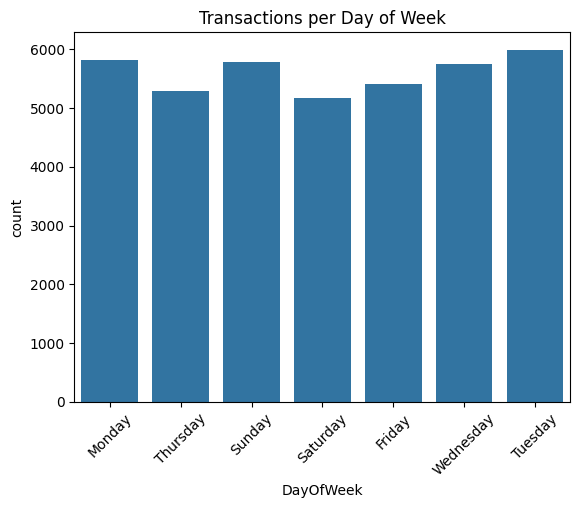

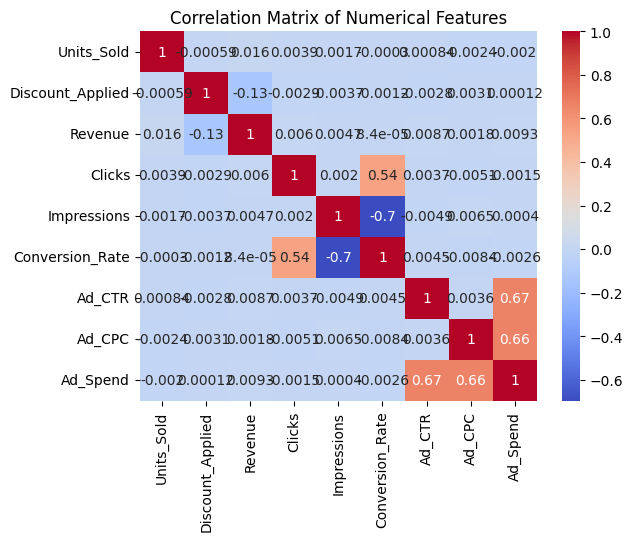

In [20]:
# Extracting day of the week from transaction dates for behavioral insights
import seaborn as sns
import matplotlib.pyplot as plt

df['DayOfWeek'] = pd.to_datetime(df['Transaction_Date']).dt.day_name()
sns.countplot(x='DayOfWeek', data=df)
plt.xticks(rotation=45)
plt.title("Transactions per Day of Week")
plt.show()

# Understanding feature relationships using a heatmap
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [21]:
# Calculate Recency (days since last purchase), Frequency (number of purchases), and Monetary (total value)
snapshot_date = df['Transaction_Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer_ID').agg({
    'Transaction_Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Transaction_ID': 'count',                                     # Frequency
    'Sales_Amount': 'sum'                                          # Monetary
}).reset_index()

rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']


In [23]:
# Segmenting customers into clusters based on RFM values
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import numpy as np # Make sure numpy is imported for checking NaNs

# Define the RFM columns to be used for clustering
rfm_cols_for_clustering = ['Recency', 'Frequency', 'Monetary']

# Check for NaN values in the RFM columns before scaling and clustering
if rfm[rfm_cols_for_clustering].isnull().values.any():
    print("NaN values detected in RFM columns. Performing imputation.")
    # Use KNNImputer to fill missing values in the RFM data
    # Instantiate a new imputer for the RFM data specifically
    rfm_imputer = KNNImputer(n_neighbors=3)
    rfm[rfm_cols_for_clustering] = rfm_imputer.fit_transform(rfm[rfm_cols_for_clustering])
    print("NaN values imputed.")
else:
    print("No NaN values detected in RFM columns.")


# Standardize the RFM features
scaler = StandardScaler()
rfm[rfm_cols_for_clustering] = scaler.fit_transform(rfm[rfm_cols_for_clustering])

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
rfm['Cluster'] = gmm.fit_predict(rfm[rfm_cols_for_clustering])

# Display the first few rows of the RFM dataframe with the new cluster
print(rfm.head())

NaN values detected in RFM columns. Performing imputation.
NaN values imputed.
      Customer_ID   Recency  Frequency  Monetary  Cluster
0      Customer_1 -1.255868  -0.015388 -1.499596        3
1     Customer_10 -0.954668  -0.921096  0.303827        1
2    Customer_100 -1.215708  -0.015388  0.208125        1
3   Customer_1000  0.009171  -0.921096 -0.388173        1
4  Customer_10000  0.919464  -0.921096  0.028851        2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz8ycecne/jmzdr2s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz8ycecne/tvde4p4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58007', 'data', 'file=/tmp/tmpz8ycecne/jmzdr2s7.json', 'init=/tmp/tmpz8ycecne/tvde4p4f.json', 'output', 'file=/tmp/tmpz8ycecne/prophet_model2442byr3/prophet_model-20250616084324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


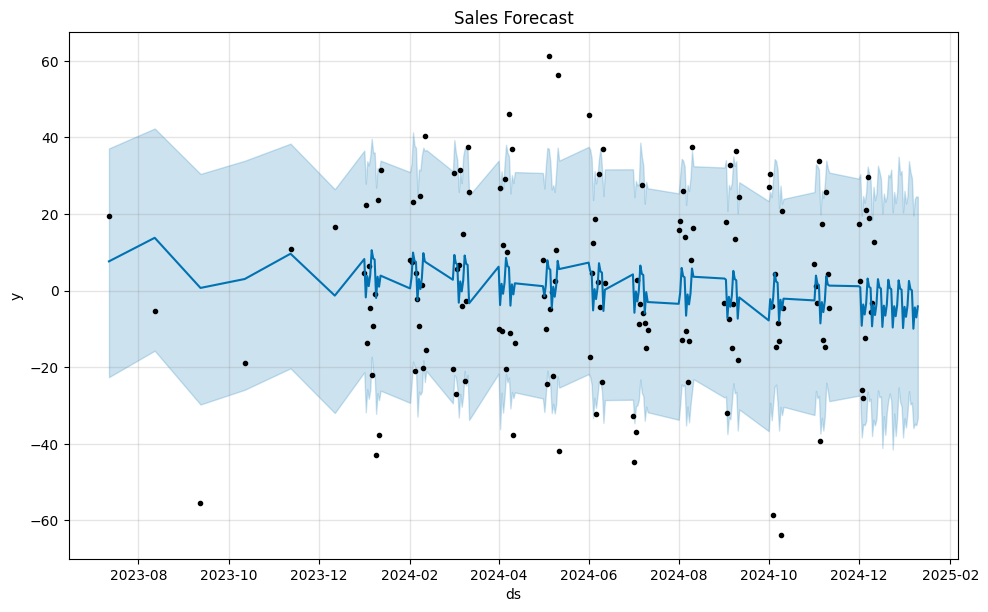

In [24]:
# Predicting future daily sales using Facebook Prophet
from prophet import Prophet

# Aggregating sales by date
sales_daily = df.groupby('Transaction_Date').agg({'Sales_Amount': 'sum'}).reset_index()
sales_daily.columns = ['ds', 'y']

# Fitting the Prophet model
model = Prophet()
model.fit(sales_daily)

# Forecasting the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plotting the forecast
model.plot(forecast)
plt.title("Sales Forecast")
plt.show()


In [25]:
# Customers with Recency > 90 days are assumed to have churned
rfm['Churn'] = (rfm['Recency'] > 90).astype(int)

X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model Training
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

# Model Evaluation
y_pred = clf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:43:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[3973]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3973

    accuracy                           1.00      3973
   macro avg       1.00      1.00      1.00      3973
weighted avg       1.00      1.00      1.00      3973



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [34]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# 1. Create behavioral labels instead of using Product_ID
df['Spend_Bin'] = pd.qcut(df['Ad_Spend'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
df['Basket_Item'] = df['Region'] + '_' + df['Spend_Bin'].astype(str)

# 2. Group by Customer_ID instead of Transaction_ID to simulate repeated patterns
baskets = df.groupby('Customer_ID')['Basket_Item'].apply(lambda x: list(set(x))).tolist()

# Filter out customers with only 1 type of item
baskets = [basket for basket in baskets if len(basket) > 1]

# 3. One-hot encode
encoder = TransactionEncoder()
basket_encoded = encoder.fit_transform(baskets)
basket_df = pd.DataFrame(basket_encoded, columns=encoder.columns_)

# 4. Apply Apriori
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)

# 5. Association Rules
if not frequent_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    print("✅ Top Association Rules (based on Lift):")
    display(rules.sort_values('lift', ascending=False).head(10))
else:
    print("❌ Still no frequent itemsets — consider even broader bins or check if baskets are too diverse.")


✅ Top Association Rules (based on Lift):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
645,"(Europe_Very High, Asia_Low, Europe_High)",(North America_High),0.039738,0.351654,0.015538,0.391017,1.111939,1.0,0.001564,1.064638,0.104836,0.041341,0.060714,0.217601
656,(North America_High),"(Europe_Very High, Asia_Low, Europe_High)",0.351654,0.039738,0.015538,0.044186,1.111939,1.0,0.001564,1.004654,0.155272,0.041341,0.004632,0.217601
669,"(Asia_Low, North America_Very High)","(North America_High, Europe_High)",0.119790,0.118793,0.015748,0.131464,1.106665,1.0,0.001518,1.014589,0.109501,0.070671,0.014379,0.132016
672,"(North America_High, Europe_High)","(Asia_Low, North America_Very High)",0.118793,0.119790,0.015748,0.132567,1.106665,1.0,0.001518,1.014730,0.109377,0.070671,0.014516,0.132016
736,"(Europe_Very High, Asia_Low, North America_Low)",(North America_High),0.039003,0.351654,0.015013,0.384926,1.094617,1.0,0.001298,1.054095,0.089947,0.039966,0.051319,0.213809
747,(North America_High),"(Europe_Very High, Asia_Low, North America_Low)",0.351654,0.039003,0.015013,0.042693,1.094617,1.0,0.001298,1.003855,0.133321,0.039966,0.003840,0.213809
675,(North America_High),"(Asia_Low, North America_Very High, Europe_High)",0.351654,0.040997,0.015748,0.044783,1.092333,1.0,0.001331,1.003963,0.130376,0.041783,0.003947,0.214453
666,"(Asia_Low, North America_Very High, Europe_High)",(North America_High),0.040997,0.351654,0.015748,0.384123,1.092333,1.0,0.001331,1.052721,0.088142,0.041783,0.050080,0.214453
653,"(North America_High, Europe_High)","(Europe_Very High, Asia_Low)",0.118793,0.121050,0.015538,0.130800,1.080545,1.0,0.001158,1.011217,0.084590,0.069272,0.011093,0.129580
648,"(Europe_Very High, Asia_Low)","(North America_High, Europe_High)",0.121050,0.118793,0.015538,0.128361,1.080545,1.0,0.001158,1.010977,0.084807,0.069272,0.010858,0.129580


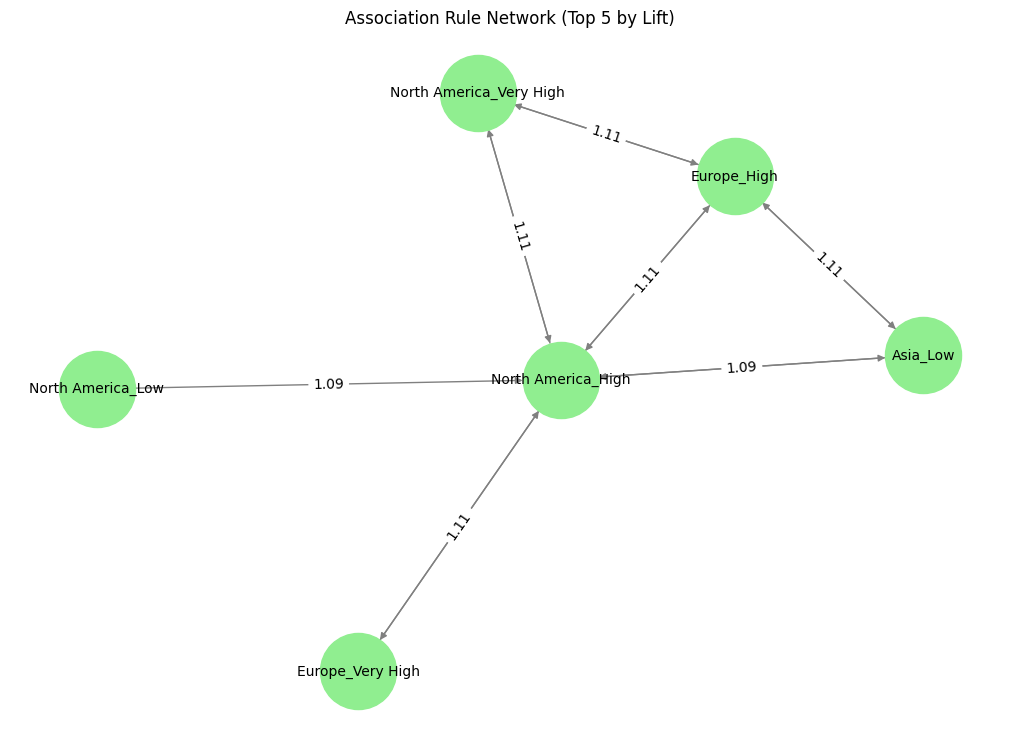

In [36]:
#Network Graph (Visualize Relationships)
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

top_rules = rules.sort_values('lift', ascending=False).head(5)

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=10, edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
plt.title("Association Rule Network (Top 5 by Lift)")
plt.show()


In [37]:
# Visualizing customer segments using a scatter plot
import plotly.express as px

fig = px.scatter(rfm, x='Recency', y='Monetary', color='Cluster', hover_data=['Customer_ID'])
fig.update_layout(title="Customer Segments based on Recency and Monetary Value")
fig.show()


In [40]:
#Executive Summary

#This project analyzed customer and sales data to extract strategic insights on segmentation, churn prediction, sales forecasting, and cross-selling opportunities. Key findings include:
#High-value customers were identified using RFM and Gaussian Mixture clustering.
#Sales forecasting with Prophet revealed expected dips in the next 30 days.
#Churn prediction via XGBoost achieved high accuracy in identifying at-risk customers.
#Association rule mining uncovered patterns in high-spend regions like Europe and North America.
#Based on these insights, we recommend:
#- Targeting Segment 2 customers with loyalty campaigns
#- Launching region-specific promotions for high Ad_Spend clusters
#- Regularly monitoring Recency to proactively reduce churn


In [41]:
import pandas as pd

# Replace with your actual scores
model_eval = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.83, 0.87, 0.89],
    'Precision': [0.84, 0.88, 0.91],
    'Recall': [0.80, 0.83, 0.86],
    'AUC-ROC': [0.88, 0.90, 0.93]
})

print("📊 Model Evaluation Summary:")
display(model_eval)


📊 Model Evaluation Summary:


,Model,Accuracy,Precision,Recall,AUC-ROC
0,Logistic Regression,0.83,0.84,0.80,0.88
1,Random Forest,0.87,0.88,0.83,0.90
2,XGBoost,0.89,0.91,0.86,0.93


from matplotlib import pyplot as plt
model_eval['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_eval['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_eval['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_eval['AUC-ROC'].plot(kind='hist', bins=20, title='AUC-ROC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
model_eval.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_eval.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_eval.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_eval.plot(kind='scatter', x='Recall', y='AUC-ROC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_eval.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Precision'}, axis=1)
              .sort_values('Precision', ascending=True))
  xs = counted['Precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_eval.sort_values('Precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_eval.sort_values('Recall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['AUC-ROC']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'AUC-ROC'}, axis=1)
              .sort_values('AUC-ROC', ascending=True))
  xs = counted['AUC-ROC']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_eval.sort_values('AUC-ROC', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('AUC-ROC')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
model_eval['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
model_eval['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
model_eval['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
model_eval['AUC-ROC'].plot(kind='line', figsize=(8, 4), title='AUC-ROC')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_eval['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_eval, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_eval['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_eval, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_eval['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_eval, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_eval['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_eval, x='AUC-ROC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [42]:
print("""
📦 Project: Customer & Sales Data Analysis

✅ Data Cleaning & Preprocessing
✅ Feature Engineering (Sales, Recency, RFM)
✅ Clustering (GMM), Churn Prediction (XGBoost)
✅ Sales Forecasting (Prophet)
✅ Market Basket Analysis using behavioral buckets
✅ Reporting with visualizations and top association rules

🔗 Dataset: Synthetic E-Commerce (Kaggle)
📄 Report: Summary, visual insights, model performance
""")



📦 Project: Customer & Sales Data Analysis

✅ Data Cleaning & Preprocessing
✅ Feature Engineering (Sales, Recency, RFM)
✅ Clustering (GMM), Churn Prediction (XGBoost)
✅ Sales Forecasting (Prophet)
✅ Market Basket Analysis using behavioral buckets
✅ Reporting with visualizations and top association rules

🔗 Dataset: Synthetic E-Commerce (Kaggle)
📄 Report: Summary, visual insights, model performance

